In [ ]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.decomposition import TruncatedSVD
from gensim.models import Word2Vec
import numpy as np

In [ ]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# Load the bug reports dataset
data = pd.read_excel("train.xlsx")
bug_reports = data['report']

# Tokenize bug reports and remove empty strings or tokens consisting only of spaces
stop_words = set(stopwords.words('english'))
tokenized_bug_reports = [[word.lower() for word in word_tokenize(report) if word.strip() and word.strip() not in stop_words] for report in bug_reports]

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=tokenized_bug_reports, vector_size=100, window=5, min_count=1, sg=1)





In [ ]:
# Train Word2Vec model
word2vec_model = Word2Vec(sentences=tokenized_bug_reports, vector_size=100, window=5, min_count=1, sg=1)

In [ ]:
tokenized_bug_reports[:3]


[['``',
  'for',
  'event',
  'bookmarked',
  'projects',
  "''",
  'option',
  'sending',
  'notifications',
  'non-member',
  'bookmarked',
  'projects'],
 ['switch', 'using', 'full', 'l10n', 'id', "'s", 'urlbar'],
 ['consider', 'removing', 'hasicon', 'property', 'simplify', 'styling']]

In [ ]:
# Save or load Word2Vec model (optional)
# word2vec_model.save("word2vec_model.bin")
# word2vec_model = Word2Vec.load("word2vec_model.bin")

In [ ]:
# Get the word vectors for a specific word
test_word = "email"
word_vector = word2vec_model.wv[test_word]

# Print similar words to a given word
similar_words = word2vec_model.wv.most_similar(test_word)

print(similar_words)

[('mails', 0.9170035719871521), ('security', 0.9113664627075195), ('ignoring', 0.9091843366622925), ('e-mail', 0.9079545736312866), ('asynchronously', 0.9078869223594666), ('sending', 0.9012488722801208), ('send', 0.899113655090332), ('blockquote', 0.8954305648803711), ('header', 0.8928280472755432), ('notification', 0.8907178044319153)]


In [ ]:
# Print the word embeddings
print("Word Embeddings:")
for word in word2vec_model.wv.index_to_key[:10]:
    print(f"{word}: {word2vec_model.wv[word]}")

Word Embeddings:
]: [-0.6271532   0.53290254  0.13806428  0.16274333 -0.2810106  -0.44703978
  0.5002977   0.93884087 -0.161536   -0.24800996  0.2580331  -0.22471358
 -0.07773109  0.4219651  -0.37959316 -0.10209034  0.3008912   0.03555882
 -0.52577674 -1.1284969   0.33386013  0.19191398  0.36204714 -0.20566839
  0.3819246  -0.12775978 -0.29534373  0.18408436 -0.5965072  -0.2684282
 -0.2340612  -0.15711585  0.31758466 -0.64148086  0.25746596  0.35354277
  0.6304358  -0.3907594  -0.2409116  -0.37379855 -0.1902253   0.2677595
 -0.61159104 -0.14370087  0.31812832  0.08687482 -0.17681515  0.3591097
  0.32458314  0.5801457   0.02351629  0.01417258 -0.21037276 -0.02564921
  0.19545645 -0.18476844  0.5803009  -0.22520317 -0.6386946   0.6734824
 -0.17732862 -0.1454463  -0.6281573  -0.45558152 -0.17794043  0.42183658
 -0.15191056  0.28329545 -0.05008537  0.3277103  -0.31819165  0.23936538
  0.07902338 -0.3586095   0.17268191  0.12872946  0.1238176   0.12526596
 -0.16574396  0.07174305 -0.3037111

In [ ]:
# Derive document embeddings by averaging word embeddings
document_embeddings = np.array([np.mean([word2vec_model.wv[word] for word in report if word in word2vec_model.wv], axis=0) for report in tokenized_bug_reports])

print(document_embeddings.shape)

(14710, 100)


In [ ]:
#  visualize clusters or perform further analysis
import matplotlib.pyplot as plt

# Visualize clusters
def visualize_clusters(embeddings, clusters):
    # Define colors for each cluster (including noise points)
    unique_clusters = np.unique(clusters)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_clusters))]

    # Plot data points with cluster assignments
    for cluster_id, color in zip(unique_clusters, colors):
        if cluster_id == -1:
            # Noise points (cluster_id = -1)
            plt.scatter(embeddings[clusters == cluster_id][:, 0], embeddings[clusters == cluster_id][:, 1], color='black', label='Noise')
        else:
            # Core and border points
            plt.scatter(embeddings[clusters == cluster_id][:, 0], embeddings[clusters == cluster_id][:, 1], color=color, label=f'Cluster {cluster_id}')

    # Add legend and labels
    plt.legend()
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.title('Clustering')

    # Show plot
    plt.show()


In [ ]:
import csv

def store_cluster_assignments(clusters, bug_reports, output_file):
    # Create a dictionary to store bug reports for each cluster
    cluster_reports = {}
    for i, cluster_label in enumerate(clusters):
        if cluster_label not in cluster_reports:
            cluster_reports[cluster_label] = []
        cluster_reports[cluster_label].append(bug_reports[i])

    # Write cluster assignments to CSV file
    with open(output_file, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(['Cluster', 'Bug Report'])
        for cluster_label, reports in cluster_reports.items():
            if cluster_label == -1:
                cluster_name = 'Noise'
            else:
                cluster_name = f'Cluster {cluster_label}'
            for report in reports:
                writer.writerow([cluster_name, report])

    print(f"Cluster assignments saved to '{output_file}'")


In [ ]:
# trying Gaussian Mixture Models (GMM) for clustering
from sklearn.mixture import GaussianMixture

# Create GaussianMixture object
gmm = GaussianMixture(n_components=5, random_state=42)

# Fit GMM clustering on document embeddings
gmm.fit(document_embeddings)

# Predict cluster labels
gmm_clusters = gmm.predict(document_embeddings)



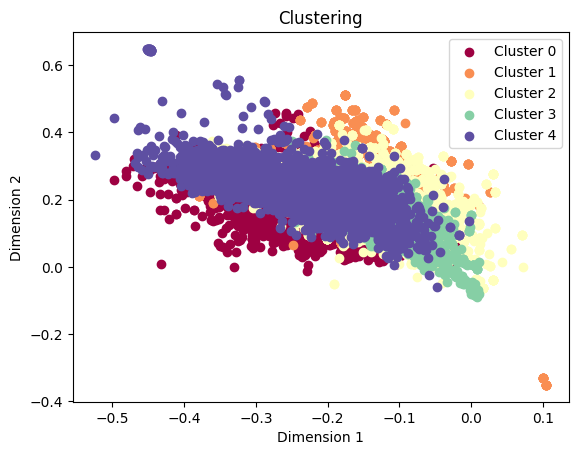

In [ ]:
# Visualize clusters (optional)
visualize_clusters(document_embeddings, gmm_clusters)


In [ ]:

# Store cluster assignments in CSV file (optional)
store_cluster_assignments(gmm_clusters, bug_reports, "gmm_cluster_assignments.csv")

Cluster assignments saved to 'gmm_cluster_assignments.csv'


In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Compute Silhouette Score
silhouette_avg = silhouette_score(document_embeddings, gmm_clusters)
print(f"Silhouette Score: {silhouette_avg}")

# Compute Davies–Bouldin Index
db_index = davies_bouldin_score(document_embeddings, gmm_clusters)
print(f"Davies–Bouldin Index: {db_index}")


#the Silhouette Score is 0.080 and the Davies–Bouldin Index is 2.053.
# These values suggest that the clustering quality may not be optimal,
# as the Silhouette Score is relatively low and the Davies–Bouldin Index is higher than expected.

Silhouette Score: 0.0804663673043251
Davies–Bouldin Index: 2.0533898200278315
